# Amazon Fine Food Reviews Analysis

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454
Number of users: 256,059
Number of products: 74,258
Timespan: Oct 1999 - Oct 2012
Number of Attributes/Columns in data: 10

Attribute Information:

    1. Id
    2. ProductId - unique identifier for the product
    3. UserId - unqiue identifier for the user
    4. ProfileName
    5. HelpfulnessNumerator - number of users who found the review helpful
    6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
    7. Score - rating between 1 and 5
    8. Time - timestamp for the review
    9. Summary - brief summary of the review
    10. Text - text of the review
    
Objective:

1. Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2) 
2. t-SNE visualization of Amazon reviews with polarity based color-coding

[Q] How to determine if a review is positive or negative?

[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

Loading the dataset:-



In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

con = sqlite3.connect('database.sqlite')

filtered_data = pd.read_sql_query("""
SELECT * 
FROM Reviews
WHERE Score != 3
""", con)

def partition(x) :
    if x < 3:
        return 'negative'
    return 'positive'

actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition)
filtered_data['Score'] = positiveNegative

In [2]:
filtered_data.shape
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  Exploratory Data Analysis
## Data Cleaning: Deduplication

In [3]:
#sorting data
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [4]:
final=sorted_data.drop_duplicates(subset={"UserId", "ProfileName","Time", "Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [5]:
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [6]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [7]:
print(final.shape)
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

# Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

    Begin by removing the html tags
    Remove any punctuations or limited set of special characters like , or . or # etc.
    Check if the word is made up of english letters and is not alpha-numeric
    Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
    Convert the word to lowercase
    Remove Stopwords
    Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)

After which we collect the words used to describe positive and negative reviews

In [8]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')

def cleanhtml (sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))
    

{'those', 'once', 'yours', 's', 'this', 'were', 'him', 'which', 'with', 'weren', 'does', "you've", 'these', 'more', 'during', 'in', 'his', 'off', "should've", "haven't", 'some', 'down', "shouldn't", 'as', 'between', 'above', 'she', 'wasn', 'the', 'didn', 'but', 'hasn', 'again', 't', 'now', 'wouldn', 'about', 'doesn', 'under', "won't", 've', 'or', 'here', 'are', "you'd", 'haven', 'll', 'further', 'myself', 'being', 'you', 'himself', 'don', 'o', "you'll", 'it', 'other', "couldn't", 'been', 'did', 'itself', 'needn', 'same', 'hadn', "isn't", 'than', 'mustn', "wasn't", 'below', 're', 'very', 'shouldn', 'nor', 'too', 'both', 'them', 'after', 'against', 'to', 'any', "mightn't", 'when', 'not', 'me', 'each', 'have', 'had', "mustn't", 'ours', 'we', 'an', "wouldn't", 'its', 'hers', 'he', "doesn't", 'my', 'while', 'do', "hadn't", 'by', 'themselves', 'couldn', 'i', 'then', 'into', 'is', 'aren', "needn't", 'doing', 'your', 'up', 'few', 'theirs', 'at', 'her', 'be', 'shan', 'only', 'yourselves', 'what

In [9]:
i=0
str1=' '
final_string=[]
all_positive_words=[]
all_negative_words=[]
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [10]:
final['CleanedText']=final_string

In [11]:
#final.head(3)

conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

# Bag of Words (BoW)

In [12]:
#BOW
count_vect = CountVectorizer()
final_counts = count_vect.fit_transform(final['Text'].values)

In [13]:
type(final_counts)

scipy.sparse.csr.csr_matrix

In [14]:
final_counts.get_shape()

(364171, 115281)

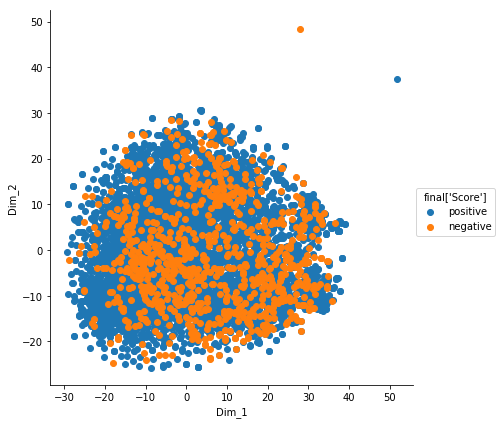

In [16]:
# TSNE

from sklearn.manifold import TSNE
data_10 = final_counts[0:5000,:].todense()
labels_10 = final['Score'][0:5000]
#print(data_10)

#data_10000.todense()
#data_10000.toarray()
model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(data_10)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_10)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "final['Score']"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="final['Score']", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()


Observation: we can observe that there are positive  points which are present in abundance. the negative points are overlapping the 
    positive counterparts.

# Bi-Grams and n-Grams

In [12]:
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most common Positive Words :", freq_dist_positive.most_common(20))
print("Most common Negative Words :", freq_dist_negative.most_common(20))

Most common Positive Words : [(b'like', 139429), (b'tast', 129047), (b'good', 112766), (b'flavor', 109624), (b'love', 107357), (b'use', 103888), (b'great', 103870), (b'one', 96726), (b'product', 91033), (b'tri', 86791), (b'tea', 83888), (b'coffe', 78814), (b'make', 75107), (b'get', 72125), (b'food', 64802), (b'would', 55568), (b'time', 55264), (b'buy', 54198), (b'realli', 52715), (b'eat', 52004)]
Most common Negative Words : [(b'tast', 34585), (b'like', 32330), (b'product', 28218), (b'one', 20569), (b'flavor', 19575), (b'would', 17972), (b'tri', 17753), (b'use', 15302), (b'good', 15041), (b'coffe', 14716), (b'get', 13786), (b'buy', 13752), (b'order', 12871), (b'food', 12754), (b'dont', 11877), (b'tea', 11665), (b'even', 11085), (b'box', 10844), (b'amazon', 10073), (b'make', 9840)]


In [13]:
#bi-gram, tri-gram and n-gram
#'not' should be avoided from removing

count_vect = CountVectorizer(ngram_range=(1,2) )
final_bigram_counts = count_vect.fit_transform(final['Text'].values)

In [22]:
final_bigram_counts.get_shape()

(364171, 2910192)

In [39]:
bgm = final_bigram_counts[0:5000,0:5000]
bgm.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

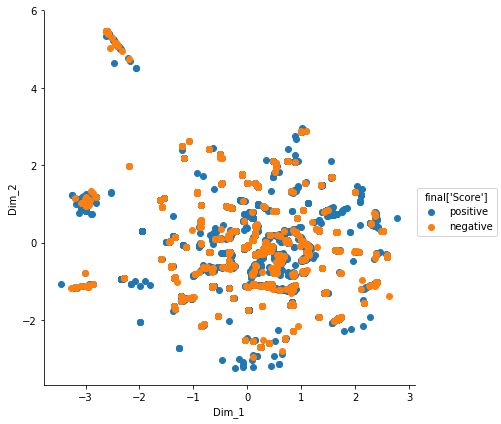

In [40]:
# TSNE

from sklearn.manifold import TSNE
data_10 = bgm.toarray()
labels_10 = final['Score'][0:5000]
#print(data_10)

#data_10000.todense()
#data_10000.toarray()
model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(data_10)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_10)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "final['Score']"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="final['Score']", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()


# TF-IDF

In [44]:
final['Text'].shape

(364171,)

In [45]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final['Text'].values[0:2000])

In [46]:
final_tf_idf.get_shape()

(2000, 98992)

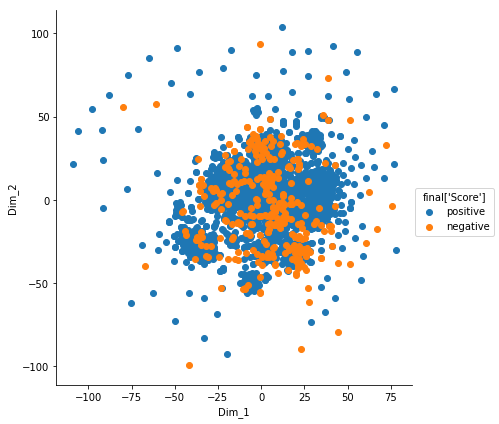

In [17]:
# TSNE

from sklearn.manifold import TSNE
data_10 = final_tf_idf.todense()
labels_10 = final['Score'][0:2000]

model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(data_10)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_10)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "final['Score']"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="final['Score']", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()


In [47]:
features = tf_idf_vect.get_feature_names()
len(features)

98992

# Word2Vec

In [14]:
#Training our own Word2Vec model using our text corpus
import gensim
i=0
list_of_sent=[]
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
    

In [16]:
print(final['Text'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
*****************************************************************
['this', 'witty', 'little', 'book', 'makes', 'my', 'son', 'laugh', 'at', 'loud', 'i', 'recite', 'it', 'in', 'the', 'car', 'as', 'were', 'driving', 'along', 'and', 'he', 'always', 'can', 'sing', 'the', 'refrain', 'hes', 'learned', 'about', 'whales', 'india', 'drooping', 'i', 'love', 'all', 'the', 'new', 'words', 'this', 'book', 'introduces', 'and', 'the', 'silliness', 'of', 'it', 'all', 'this', 'is', 'a', 'classic', 'book', 'i', 'am', 'willing', 'to', 'bet', 'my', 'son', 'will', 'still', 'be', 'able', 'to', 'recite', 'from', 'memory', 'when', 'he', 'is'

In [29]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)    


In [30]:
words = list(w2v_model.wv.vocab)
print(len(words))

33783


In [31]:
w2v_model.wv.most_similar('mom')

[('dad', 0.9493998289108276),
 ('mother', 0.931469202041626),
 ('sister', 0.923061728477478),
 ('father', 0.9136614203453064),
 ('brother', 0.8990861773490906),
 ('grandson', 0.8957883715629578),
 ('boyfriend', 0.8864396810531616),
 ('granddaughter', 0.8829728364944458),
 ('girlfriend', 0.879116952419281),
 ('niece', 0.8784171938896179)]

In [32]:
X = w2v_model[w2v_model.wv.vocab]

C:\Users\Shamim Ahmed\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


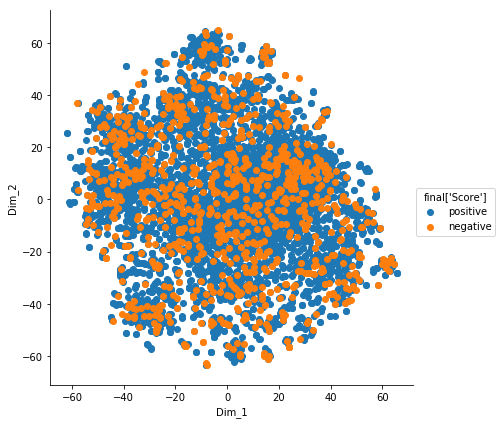

In [34]:
# TSNE

from sklearn.manifold import TSNE
data_10 = X[0:5000]
labels_10 = final['Score'][0:5000]

model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(data_10)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_10)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "final['Score']"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="final['Score']", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# Avg W2V

In [40]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

C:\Users\Shamim Ahmed\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


364171
50


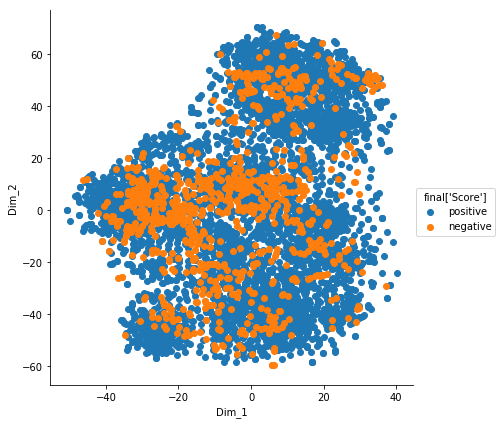

In [42]:
# TSNE

from sklearn.manifold import TSNE
data_10 = sent_vectors[0:5000]
labels_10 = final['Score'][0:5000]

model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(data_10)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_10)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "final['Score']"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="final['Score']", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# Summary

In case of Average word2vec we can observe some clear distiction between the positive and negative reviews.